In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.utils import shuffle
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge

In [2]:
#import file
df = pd.read_excel('realperm.xlsx')
df.shape

(900, 8)

In [3]:
#exploratory data analysis (EDA)
df.head()

,Water_sat,Temp,Oil_viscosity,Perm_k,Swi,Flow_rate,Rel_perm_o,Rel_perm_w
0,0.196679,80,13.46425,5.01,0.21,0.5,1.000000,0.000000e+00
1,0.210624,80,13.46425,5.01,0.21,0.5,0.921935,1.075810e-10
2,0.224570,80,13.46425,5.01,0.21,0.5,0.848511,5.856070e-09
3,0.238515,80,13.46425,5.01,0.21,0.5,0.779542,6.067730e-08
4,0.252460,80,13.46425,5.01,0.21,0.5,0.714845,3.187700e-07


In [4]:
import seaborn as sns
df.describe()

,Water_sat,Temp,Oil_viscosity,Perm_k,Swi,Flow_rate,Rel_perm_o,Rel_perm_w
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,0.523384,60.000000,38.073744,5.545556,0.210556,0.750000,0.135423,0.168796
std,0.190009,16.339011,25.619674,0.785316,0.052467,0.204238,0.238172,0.213096
min,0.107445,40.000000,13.464250,4.590000,0.110000,0.500000,0.000000,0.000000
25%,0.363984,40.000000,19.291038,5.020000,0.170000,0.500000,0.000487,0.003388
50%,0.524354,60.000000,32.023564,5.200000,0.235000,0.750000,0.016216,0.061889
75%,0.683675,80.000000,37.864132,6.010000,0.250000,1.000000,0.148150,0.283415
max,0.889211,80.000000,83.552248,7.120000,0.280000,1.000000,1.000000,0.959514


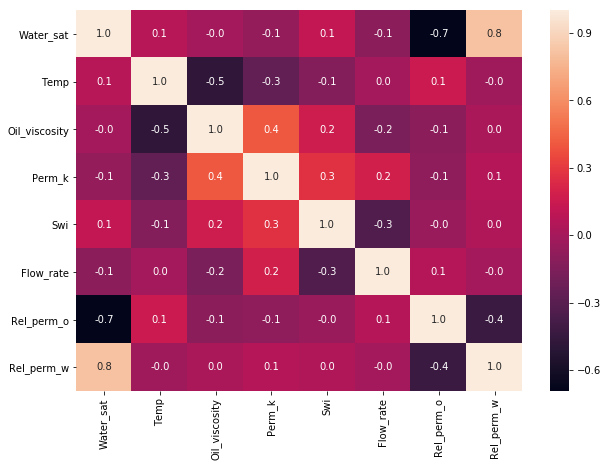

In [5]:
#You can also plot a heat map to understand how each feature correlates to the other (Do they go hand in hand or are they inversely propotional)
f= plt.subplots(figsize=(10,7))

sns.heatmap(df.corr(),annot=True,fmt='.1f',color='green')  #We can use a simple seaborn method to draw the heatmaps

In [6]:
#The next step is to find a pattern in the scatter plots to be able to use Support Vector Machines and finding the fault line of the Earthquakes

#pd.plotting.scatter_matrix(df.loc[0:,df.columns],c=['red','blue'],alpha=0.5,figsize=[25,25],diagonal='hist',s=200,marker='.',edgecolor='black')
plt.show()

# separate the dataset for oil and water

In [7]:
dfo = df.iloc[:, 0:-1]

In [8]:
dfo.head()

,Water_sat,Temp,Oil_viscosity,Perm_k,Swi,Flow_rate,Rel_perm_o
0,0.196679,80,13.46425,5.01,0.21,0.5,1.000000
1,0.210624,80,13.46425,5.01,0.21,0.5,0.921935
2,0.224570,80,13.46425,5.01,0.21,0.5,0.848511
3,0.238515,80,13.46425,5.01,0.21,0.5,0.779542
4,0.252460,80,13.46425,5.01,0.21,0.5,0.714845


In [9]:
dfw = df.iloc[:, [0,1,2,3,4,5,7]]

In [10]:
dfw.head()

,Water_sat,Temp,Oil_viscosity,Perm_k,Swi,Flow_rate,Rel_perm_w
0,0.196679,80,13.46425,5.01,0.21,0.5,0.000000e+00
1,0.210624,80,13.46425,5.01,0.21,0.5,1.075810e-10
2,0.224570,80,13.46425,5.01,0.21,0.5,5.856070e-09
3,0.238515,80,13.46425,5.01,0.21,0.5,6.067730e-08
4,0.252460,80,13.46425,5.01,0.21,0.5,3.187700e-07


# Oil data modelling

In [11]:
#setting independent variables as X and dependent varibale as y
X= dfo.iloc[:,:-1]    
y = dfo.iloc[:, -1]

In [12]:
#normalizing the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

## Shuffle the data

In [13]:
seed = 42
X, y = shuffle(X, y, random_state=seed)

In [14]:
def svr_model(X, y):
    gsc = GridSearchCV(
        estimator=SVR(kernel='linear'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)


    best_params = grid_result.best_params_
    best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"], coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}

    scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    return "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean()))
# Run 
print(svr_model(X,y))

('MAE :', 0.11245500175809538, '| RMSE :', 0.1681098239036041)


In [21]:
svr_model(X,y)

('MAE :', 0.11245500175809538, '| RMSE :', 0.1681098239036041)

In [16]:
'''from sklearn.model_selection import cross_val_predict
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
predicted = cross_val_predict(svr_model, X, y, cv=10)

fig, ax = plt.subplots()
ax.scatter(y, predicted)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()'''

"from sklearn.model_selection import cross_val_predict\n# cross_val_predict returns an array of the same size as `y` where each entry\n# is a prediction obtained by cross validation:\npredicted = cross_val_predict(svr_model, X, y, cv=10)\n\nfig, ax = plt.subplots()\nax.scatter(y, predicted)\nax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)\nax.set_xlabel('Measured')\nax.set_ylabel('Predicted')\nplt.show()"

# water data modelling

In [35]:
#setting independent variables as X and dependent varibale as y
X= dfw.iloc[:,:-1]    
y = dfw.iloc[:, -1]

In [36]:
#normalizing the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

## shuffle that data

In [37]:
seed = 42
X, y = shuffle(X, y, random_state=seed)

In [39]:
def svr_model(X, y):
    gsc = GridSearchCV(
        estimator=SVR(kernel='rbf'),
        param_grid={
            'C': [0.1, 1, 100, 1000],
            'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

    grid_result = gsc.fit(X, y)


    best_params = grid_result.best_params_
    best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"], coef0=0.1, shrinking=True,
                   tol=0.001, cache_size=200, verbose=False, max_iter=-1)

    scoring = {
               'abs_error': 'neg_mean_absolute_error',
               'squared_error': 'neg_mean_squared_error'}

    scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    return "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean()))
# Run 
print(svr_model(X,y))

('MAE :', 0.08962314779386839, '| RMSE :', 0.12158072147730223)
